In [2]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTENC, SMOTE

## Load and Clean Data

In [4]:
# Load Dataset

file_path = "/Users/Sebastiano/data/Clinical_MRI.xlsx"
db = pd.read_excel(file_path)

print("N° of patients: {}".format(len(db)))
print("N° of columns: {}".format(db.shape[1]))
db.head()

N° of patients: 27
N° of columns: 969


,Patient,Date of Birth,Gender,Education,Disease duration (months),Age,SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,30084,0,High School,109.5,38.00,0,0.0,1,1,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,26505,0,University,96.0,41.17,13,2.1,0,1,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,31954,0,University,76.5,32.00,2,0.5,0,1,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,32438,0,University,79.1,31.00,2,0.0,1,1,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,28445,0,high school,42.0,43.00,2,0.4,0,1,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [5]:
# Drop unwanted columns

df = db.drop(['Patient','Date of Birth', 'Gender', 'Education', 'Age'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 963 


In [4]:
## transform columns with high skewness.
#skewness = df.skew()
# Identify columns with high skewness
#high_skew_cols = skewness[abs(skewness) > 1].index.tolist()
#print('-------------------')
#print('High skewness columns:')
#print(high_skew_cols)

# Apply log transformation to high skewness columns
#for col in high_skew_cols:
 #   df[col] = np.log1p(df[col])

#df = df.fillna(df.median())

In [6]:
# One Hot Encoding for Scores, Antiplatelets and Coagulants, Therapy, NP Event

from sklearn.preprocessing import OneHotEncoder

categ = ['Antiplatelet', 'Anticoagulant', 'Antimalarial', 'Immunosuppressant', 'Biologic']
ohe = OneHotEncoder(categories='auto',sparse=False)
df_enc = ohe.fit_transform(df[categ])
df_enc = pd.DataFrame(df_enc,columns=ohe.get_feature_names_out(categ))
df = pd.concat([df, df_enc], axis=1)
df = df.drop(categ, axis=1)
df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Disease duration (months),SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),anti-dsDNA Titre (insert NV here <7 ),Anti-Ro-SSA,Anti-La-SSB,Anti-RNP,anti-Sm,...,Immunosuppressant_Azathioprine,Immunosuppressant_Cyclophosphamide,Immunosuppressant_Methotrexate,Immunosuppressant_Mycophenolate,Immunosuppressant_None,Immunosuppressant_azathioprine,Biologic_Belimumab,Biologic_None,Biologic_Rituximab,Biologic_tocilizumab
0,109.5,0,0.0,1,1,3.0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,96.0,13,2.1,0,1,84.4,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,76.5,2,0.5,0,1,4.0,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,79.1,2,0.0,1,1,5.0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,42.0,2,0.4,0,1,37.2,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
np.random.seed(42)

## Regression Analysis w/ NP-SLE as target

In [6]:
# Define the target variable
target = 'NP-SLE'

# Define the predictor variables
predictors = ['SCA thickness asymmetry', 'Amygdala right volume %', 'Temporal thickness asymmetry', 'TMP thickness asymmetry', 'MTG thickness asymmetry', 'AnAb ', 'aPL syndrome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)

# Predict the target variable for the testing set
y_pred = regressor.predict(X_test)

# Evaluate the performance of the model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)


Mean Squared Error:  0.29831871364555906
R-squared:  -1.1478947382480253


In [ ]:
# Create a scatter plot matrix of the target variable against the predictor  variables
pd.plotting.scatter_matrix(df[predictors + [target]], figsize=(30, 30))
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

random_grid = [{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# First create the base model to tune
lg = LogisticRegression(random_state=42)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
lg_random = GridSearchCV(estimator = lg, param_grid=random_grid,
                               cv = 5)
# Fit the random search model
lg_random.fit(X_train, y_train)
lg_random.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/en

{'C': 10, 'penalty': 'l2'}

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report

# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42, penalty='l2', C=10)
log_reg.fit(X_train, y_train)

# Evaluate the model on the testing data
score_log = log_reg.score(X_test, y_test)
print("### TESTING ###")
print("Logistic Regression's accuracy: ", round(score_log * 100, 2), "% \n")

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)
cm_log = confusion_matrix(y_test, y_pred)
print(cm_log, "\n")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('1. The F-1 Score of the model: {} \n'.format(round(f1_score(y_test, y_pred, average='macro'), 2)))
print('2. The Recall Score of the model: {} \n'.format(round(recall_score(y_test, y_pred, average='macro'), 2)))
print('3. Classification report:\n{}'.format(classification_report(y_test, y_pred)))
print('4. AUC:\n{}\n'.format(roc_auc))

tn, fp, fn, tp = cm_log.ravel()

# Sensitivity, hit rate, Recall, or true positive rate
tpr = tp / (tp + fn)
print("Sensitivity (TPR): {}".format(tpr))

# Specificity or true negative rate
tnr = tn / (tn + fp)
print("Specificity (TNR): {}".format(tnr))

# Precision or positive predictive value
ppv = tp / (tp + fp)
print("Precision (PPV): {}".format(ppv))

# Negative predictive value
npv = tn / (tn + fn)
print("Negative Predictive Value (NPV): {}".format(npv))

# False positive rate
fpr = fp / (fp + tn)
print("False Positive Rate (FPR): {}".format(fpr))

### TESTING ###
Logistic Regression's accuracy:  66.67 % 

[[0 1]
 [1 4]] 

1. The F-1 Score of the model: 0.4 

2. The Recall Score of the model: 0.4 

3. Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5

    accuracy                           0.67         6
   macro avg       0.40      0.40      0.40         6
weighted avg       0.67      0.67      0.67         6

4. AUC:
0.4

Sensitivity (TPR): 0.8
Specificity (TNR): 0.0
Precision (PPV): 0.8
Negative Predictive Value (NPV): 0.0
False Positive Rate (FPR): 1.0


## Regression Analysis w/ AnAb as target

/var/folders/gv/8pp24fhj55x0_14187vq2lkh0000gp/T/ipykernel_31134/3675189654.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method="spearman")


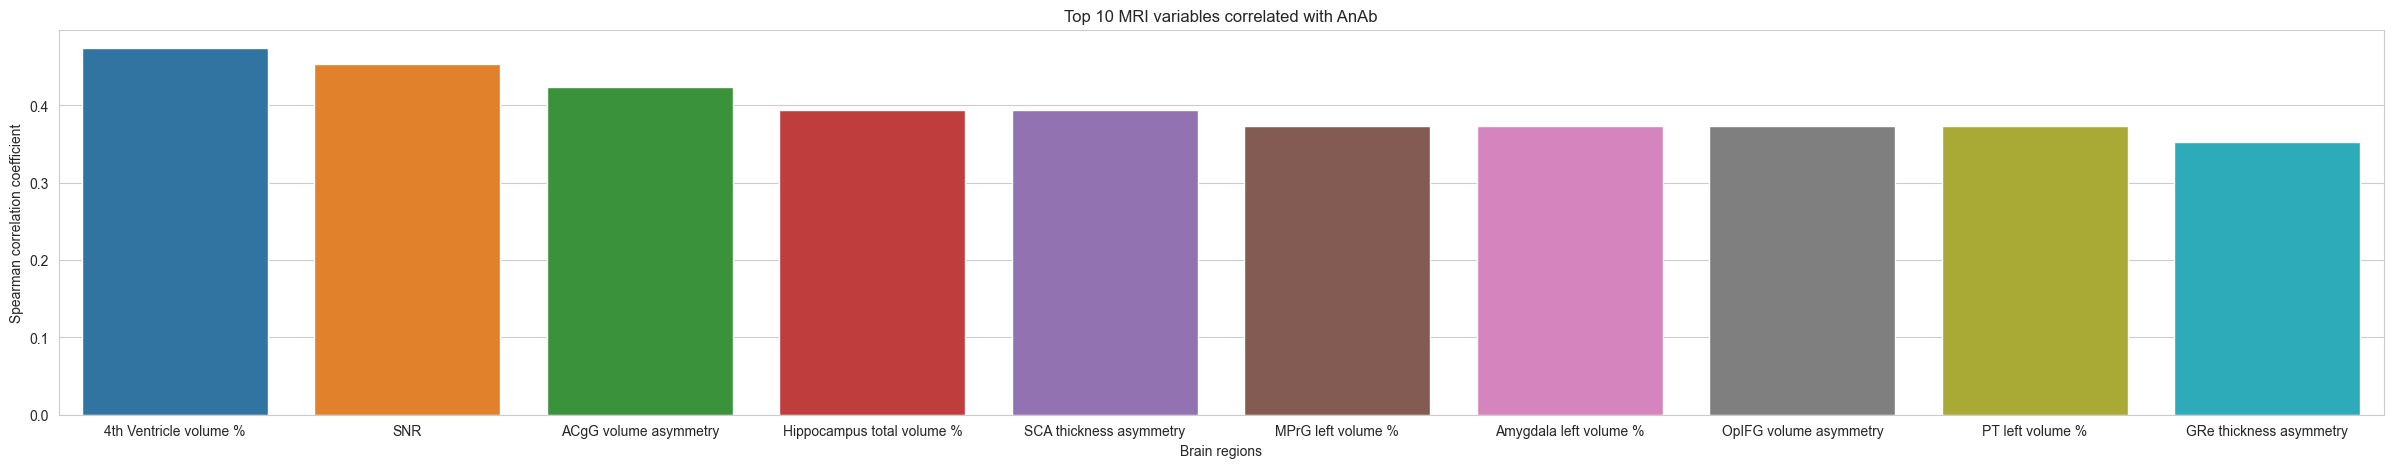

In [8]:
# Computes feature correlation
df_corr = df.corr(method="spearman")

# Select the row of the correlation matrix corresponding to 'result'
pearson_corr = df_corr.loc['AnAb ',"SNR":"PO thickness asymmetry"]

# Sort the correlations in descending order
pearson_corr = pearson_corr.sort_values(ascending=False)

# Select the top 10 correlated variables
top_10_corr = pearson_corr.iloc[1:11]

# Plot the top 10 correlations using a barplot
sns.set_style("whitegrid")
plt.figure(figsize=(30,5))
ax = sns.barplot(x=top_10_corr.index, y=top_10_corr.values)
plt.title('Top 10 MRI variables correlated with AnAb')
plt.xlabel('Brain regions')
plt.ylabel('Spearman correlation coefficient')
plt.show()

In [12]:
# Define the target variable
target = 'AnAb '

# Define the predictor variables
predictors = ['4th Ventricle volume %', 'ACgG volume asymmetry', 'Hippocampus total volume %', 'SCA thickness asymmetry', 'MPrG left volume %', 'Amygdala left volume %', 'OpIFG volume asymmetry']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

random_grid = [{'penalty' : ['l1', 'l2', 'elasticnet'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# First create the base model to tune
lg = LogisticRegression(random_state=42)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
lg_random = GridSearchCV(estimator = lg, param_grid=random_grid,
                               cv = 5)
# Fit the random search model
lg_random.fit(X_train, y_train)
lg_random.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/en

{'C': 10, 'penalty': 'l2'}

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report

# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42, penalty='l2', C=10)
log_reg.fit(X_train, y_train)

# Evaluate the model on the testing data
score_log = log_reg.score(X_test, y_test)
print("### TESTING ###")
print("Logistic Regression's accuracy: ", round(score_log * 100, 2), "% \n")

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)
cm_log = confusion_matrix(y_test, y_pred)
print(cm_log, "\n")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('1. The F-1 Score of the model: {} \n'.format(round(f1_score(y_test, y_pred, average='macro'), 2)))
print('2. The Recall Score of the model: {} \n'.format(round(recall_score(y_test, y_pred, average='macro'), 2)))
print('3. Classification report:\n{}'.format(classification_report(y_test, y_pred)))
print('4. AUC:\n{}\n'.format(roc_auc))

tn, fp, fn, tp = cm_log.ravel()

# Sensitivity, hit rate, Recall, or true positive rate
tpr = tp / (tp + fn)
print("Sensitivity (TPR): {}".format(tpr))

# Specificity or true negative rate
tnr = tn / (tn + fp)
print("Specificity (TNR): {}".format(tnr))

# Precision or positive predictive value
ppv = tp / (tp + fp)
print("Precision (PPV): {}".format(ppv))

# Negative predictive value
npv = tn / (tn + fn)
print("Negative Predictive Value (NPV): {}".format(npv))

# False positive rate
fpr = fp / (fp + tn)
print("False Positive Rate (FPR): {}".format(fpr))

### TESTING ###
Logistic Regression's accuracy:  50.0 % 

[[0 0]
 [3 3]] 

1. The F-1 Score of the model: 0.33 

2. The Recall Score of the model: 0.25 

3. Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         6

    accuracy                           0.50         6
   macro avg       0.50      0.25      0.33         6
weighted avg       1.00      0.50      0.67         6

4. AUC:
nan

Sensitivity (TPR): 0.5
Specificity (TNR): nan
Precision (PPV): 1.0
Negative Predictive Value (NPV): 0.0
False Positive Rate (FPR): nan


/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/metrics/_classif

## Regression Analysis w/ dsDNA as target

/var/folders/gv/8pp24fhj55x0_14187vq2lkh0000gp/T/ipykernel_54835/1442412968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method="spearman")


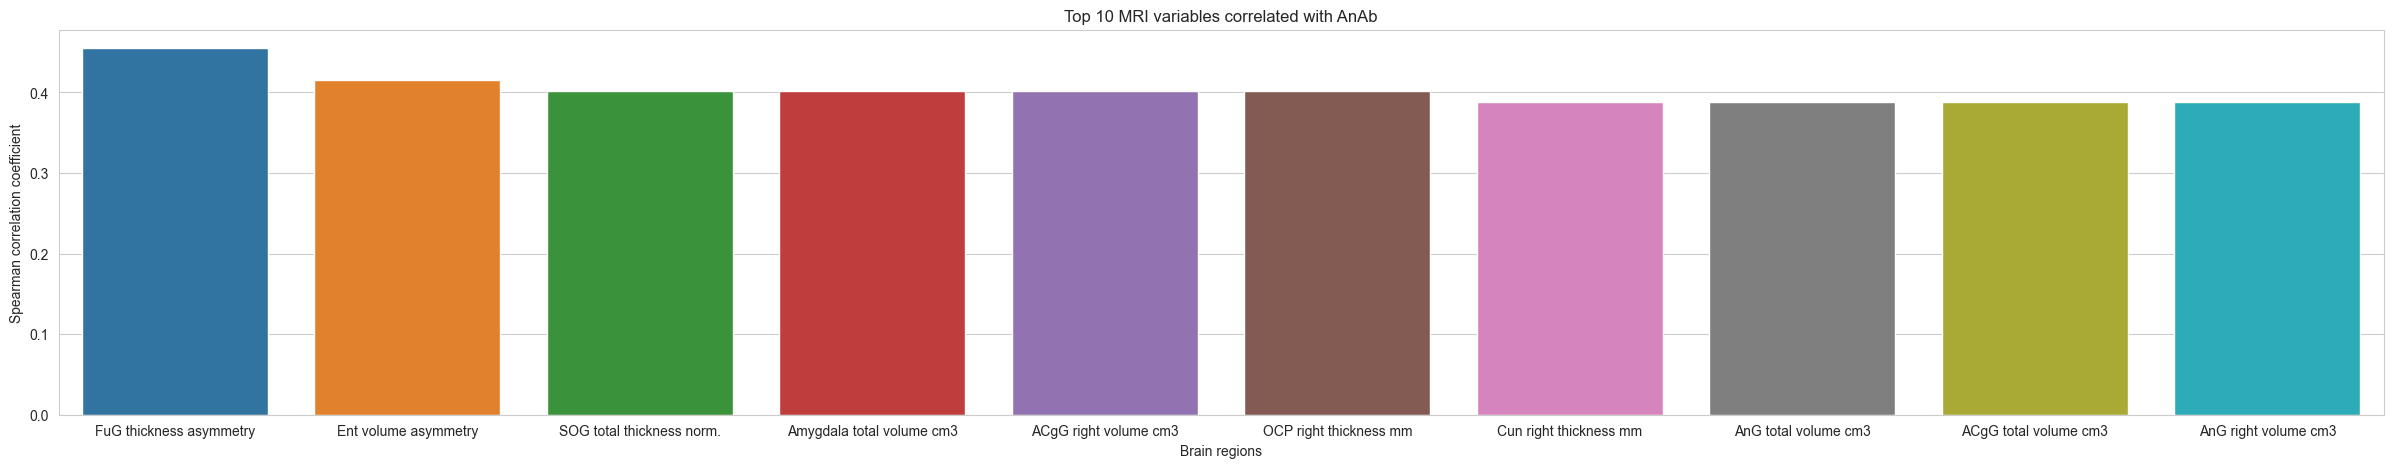

In [8]:
# Computes feature correlation
df_corr = df.corr(method="spearman")

# Select the row of the correlation matrix corresponding to 'result'
pearson_corr = df_corr.loc['anti-dsDNA Titre  (0=absent; 1=present) )',"SNR":"PO thickness asymmetry"]

# Sort the correlations in descending order
pearson_corr = pearson_corr.sort_values(ascending=False)

# Select the top 10 correlated variables
top_10_corr = pearson_corr.iloc[1:11]

# Plot the top 10 correlations using a barplot
sns.set_style("whitegrid")
plt.figure(figsize=(30,5))
ax = sns.barplot(x=top_10_corr.index, y=top_10_corr.values)
plt.title('Top 10 MRI variables correlated with AnAb')
plt.xlabel('Brain regions')
plt.ylabel('Spearman correlation coefficient')
plt.show()

In [12]:
# Define the target variable
target = 'anti-dsDNA Titre  (0=absent; 1=present) )'

# Define the predictor variables
predictors = ['FuG volume asymmetry', 'Ent volume asymmetry', 'SOG total thickness norm.', 'ACgG right volume cm3', 'OCP right thickness mm', 'Amygdala total volume %', 'Cun right thickness mm']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
os = SMOTENC(categorical_features=[1,2,3,4,5,6], k_neighbors= 3, random_state=42)
smote_x, smote_y = os.fit_resample(X_train, y_train)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

random_grid = [{'penalty' : ['l2'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# First create the base model to tune
lg = LogisticRegression(random_state=42)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
lg_random = GridSearchCV(estimator = lg, param_grid=random_grid,
                               cv = 5)
# Fit the random search model
lg_random.fit(X_train, y_train)
lg_random.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'C': 0.001, 'penalty': 'l2'}

In [32]:
class_counts = y_test.value_counts()
print("Class Distribution:")
print(class_counts)


Class Distribution:
1    6
Name: anti-dsDNA Titre  (0=absent; 1=present) ), dtype: int64


In [28]:
log_kps = LogisticRegression(random_state=42, penalty='l2', C=10)
log_kps.fit(smote_x, smote_y)

score_log = log_kps.score(X_test, y_test)
print("### TESTING ###")
print("Logistic Regression's accuracy: ", round(score_log*100,2), "% \n")

y_pred = log_kps.predict(X_test)
y_proba = log_kps.predict_proba(X_test)
cm_log = confusion_matrix(y_test, y_pred)

try:
    tn, fp, fn, tp = cm_log.ravel()

    # Sensitivity, hit rate, Recall, or true positive rate
    tpr = tp / (tp + fn)
    print("Sensitivity (TPR): {}".format(tpr))

    # Specificity or true negative rate
    tnr = tn / (tn + fp)
    print("Specificity (TNR): {}".format(tnr))

    # Precision or positive predictive value
    ppv = tp / (tp + fp)
    print("Precision (PPV): {}".format(ppv))

    # Negative predictive value
    npv = tn / (tn + fn)
    print("Negative Predictive Value (NPV): {}".format(npv))

    # False positive rate
    fpr = fp / (fp + tn)
    print("False Positive Rate (FPR): {}".format(fpr))

except ValueError:
    print("Error: Insufficient values in confusion matrix for unpacking.")
    print("Confusion Matrix:")
    print(cm_log)


### TESTING ###
Logistic Regression's accuracy:  100.0 % 

Error: Insufficient values in confusion matrix for unpacking.
Confusion Matrix:
[[6]]


## SLEDAI as target

/var/folders/gv/8pp24fhj55x0_14187vq2lkh0000gp/T/ipykernel_31134/2034727509.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method="spearman")


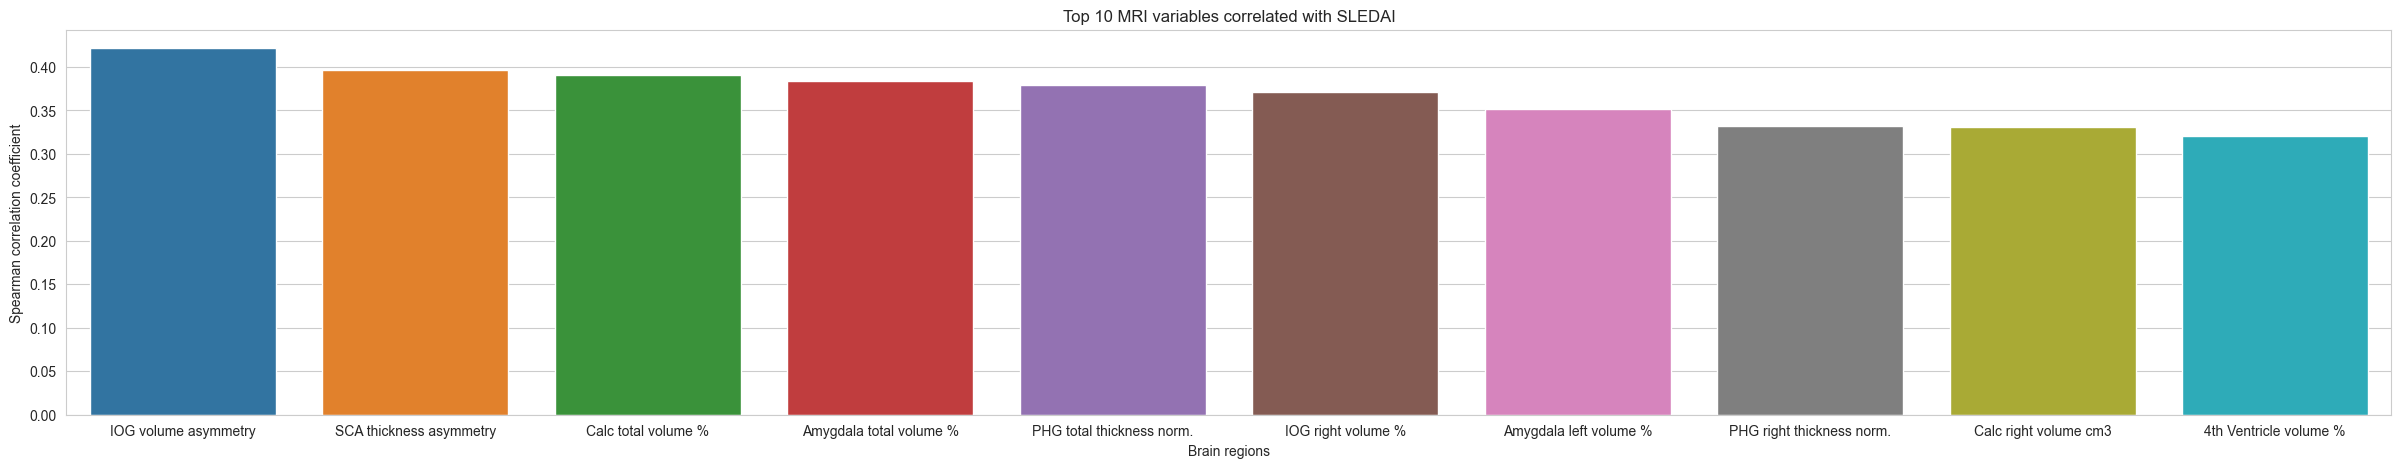

In [23]:
# Computes feature correlation
df_corr = df.corr(method="spearman")

# Select the row of the correlation matrix corresponding to 'result'
pearson_corr = df_corr.loc['SLEDAI-2k (at the time of NP event)',"SNR":"PO thickness asymmetry"]

# Sort the correlations in descending order
pearson_corr = pearson_corr.sort_values(ascending=False)

# Select the top 10 correlated variables
top_10_corr = pearson_corr.iloc[1:11]

# Plot the top 10 correlations using a barplot
sns.set_style("whitegrid")
plt.figure(figsize=(30,5))
ax = sns.barplot(x=top_10_corr.index, y=top_10_corr.values)
plt.title('Top 10 MRI variables correlated with SLEDAI')
plt.xlabel('Brain regions')
plt.ylabel('Spearman correlation coefficient')
plt.show()

In [24]:
# Define the target variable
target = 'SLEDAI-2k (at the time of NP event)'

# Define the predictor variables
predictors = ['IOG volume asymmetry', 'SCA volume asymmetry', 'Calc total volume %', 'Amygdala total volume %', 'PHG total thickness norm.', 'Amygdala left volume %', 'IOG right volume %']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

param_grid = {'fit_intercept': [True, False]}

# Create the base model to tune
lin_reg = LinearRegression()

# Grid search of parameters, using 5-fold cross-validation
lin_reg_grid = GridSearchCV(estimator=lin_reg, param_grid=param_grid, cv=5)

# Fit the grid search model
lin_reg_grid.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters: ", lin_reg_grid.best_params_)

Best parameters:  {'fit_intercept': True}


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the linear regression model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = lin_reg.predict(X_test)

# Calculate evaluation metrics for the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("### TESTING ###")
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2) Score: ", r2)


### TESTING ###
Mean Squared Error (MSE):  160.279932567625
R-squared (R2) Score:  -1.8721142719932797


## dsDNA titre

/var/folders/gv/8pp24fhj55x0_14187vq2lkh0000gp/T/ipykernel_38935/4152729045.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method="spearman")


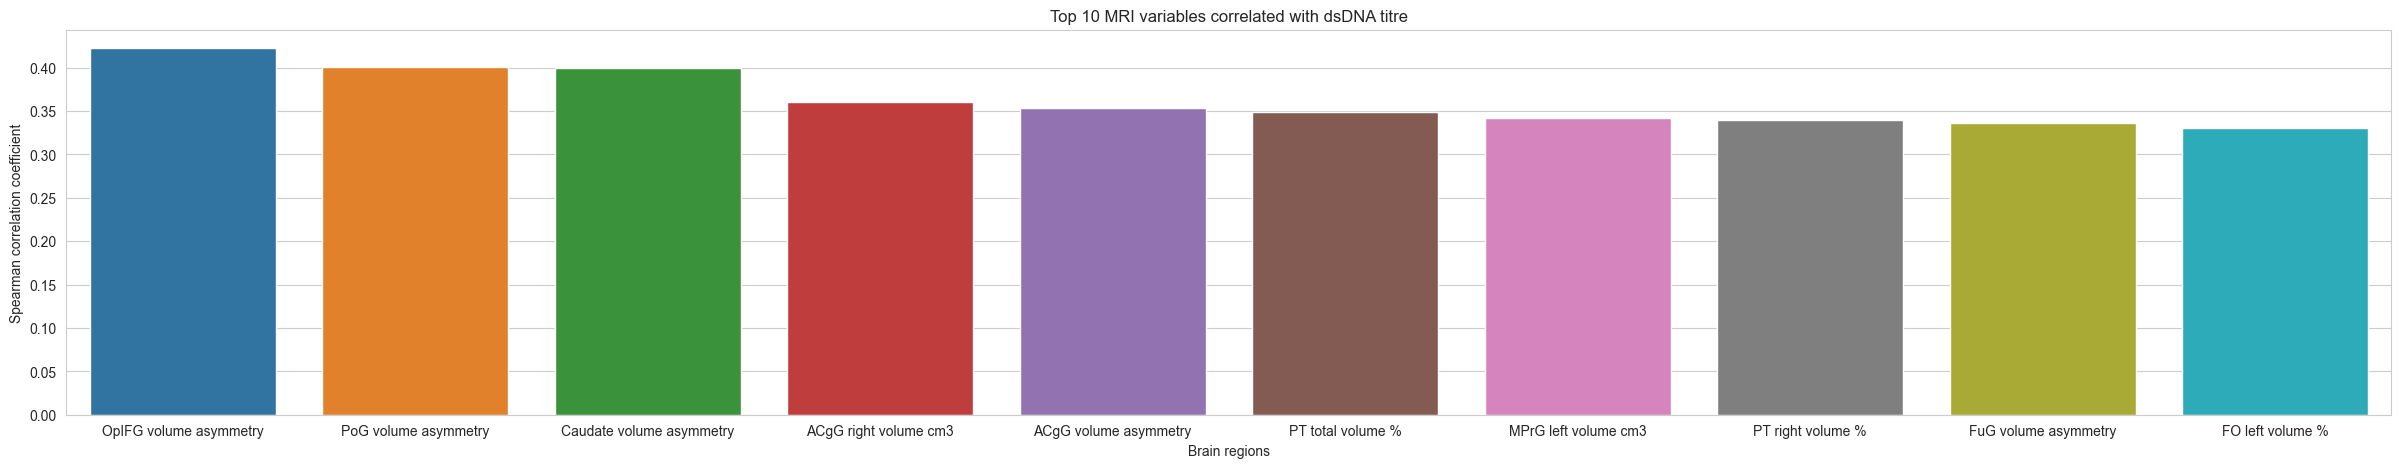

In [12]:
# Computes feature correlation
df_corr = df.corr(method="spearman")

# Select the row of the correlation matrix corresponding to 'result'
pearson_corr = df_corr.loc['anti-dsDNA Titre  (insert NV here <7 )',"SNR":"PO thickness asymmetry"]

# Sort the correlations in descending order
pearson_corr = pearson_corr.sort_values(ascending=False)

# Select the top 10 correlated variables
top_10_corr = pearson_corr.iloc[1:11]

# Plot the top 10 correlations using a barplot
sns.set_style("whitegrid")
plt.figure(figsize=(30,5))
ax = sns.barplot(x=top_10_corr.index, y=top_10_corr.values)
plt.title('Top 10 MRI variables correlated with dsDNA titre')
plt.xlabel('Brain regions')
plt.ylabel('Spearman correlation coefficient')
plt.show()

In [13]:
# Define the target variable
target = 'anti-dsDNA Titre  (insert NV here <7 )'

# Define the predictor variables
predictors = ['OpIFG volume asymmetry', 'PoG volume asymmetry', 'Caudate volume asymmetry', 'ACgG right volume cm3', 'ACgG volume asymmetry', 'MPrG left volume cm3', 'PT total volume %']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

param_grid = {'fit_intercept': [True, False]}

# Create the base model to tune
lin_reg = LinearRegression()

# Grid search of parameters, using 5-fold cross-validation
lin_reg_grid = GridSearchCV(estimator=lin_reg, param_grid=param_grid, cv=5)

# Fit the grid search model
lin_reg_grid.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters: ", lin_reg_grid.best_params_)

Best parameters:  {'fit_intercept': True}


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the linear regression model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = lin_reg.predict(X_test)

# Calculate evaluation metrics for the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("### TESTING ###")
print("Mean Squared Error (MSE): ", mse)
print("R-squared (R2) Score: ", r2)


### TESTING ###
Mean Squared Error (MSE):  29690.633512397864
R-squared (R2) Score:  -0.32468573057636974
